**Митрофанов А.А**
# Анализ тональности текста 
Анализ тональности текста направлен на автоматическое определение эмоциональной лексики и эмоциональной оценки авторов по отношению к объектам, речь о которых идёт в тексте. 
Тональность — это эмоциональное отношение автора высказывания к некоторому объекту выраженное в тексте.

В данной работе рассматривается анализ тональности текста из корпуса RuSentiment.
Данный корпус состоит из ~30 тысяч текстовых комментариев и меток тональности к каждому коментарию. 
Возможно пять меток 'skip', 'speech', 'negative', 'neutral' и 'positive'. 

In [89]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
import torch
import sklearn

from razdel import tokenize
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, ComplementNB, GaussianNB
from sklearn.metrics import classification_report, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC

from transformers import AutoTokenizer, AutoModel
from razdel import tokenize
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.linear_model import LogisticRegression
%matplotlib inline

# 1. Данные

In [3]:
ID2LABEL = ['skip', 'speech', 'negative', 'neutral', 'positive']
LABEL2ID = {l: i for i,l in enumerate(ID2LABEL)}

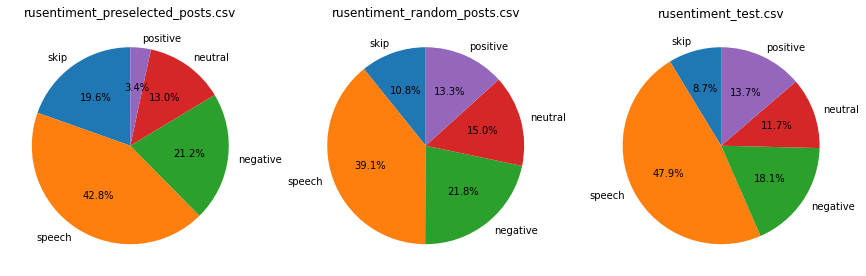

Распределение ко классам для каждого из файлов, входящих в базу RuSentiment


In [91]:
def load_data(file, ax=plt):
    # Загрузка данных и отрисовка распределения классов
    data = pd.read_csv(file)
    ax.set_title(os.path.basename(file))
    ax.pie(data.groupby('label').count().values.reshape(-1), labels=ID2LABEL, autopct='%1.1f%%',
            shadow=False, startangle=90)
    return data
#plt.figure(figsize=(10,10))
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 6))
rs_preselected = load_data('data/rusentiment/Dataset/rusentiment_preselected_posts.csv', ax1)
rs_random = load_data('data/rusentiment/Dataset/rusentiment_random_posts.csv', ax2)
rs_test = load_data('data/rusentiment/Dataset/rusentiment_test.csv', ax3)
plt.show()
print("Распределение ко классам для каждого из файлов, входящих в базу RuSentiment")

In [94]:
print(f'Распределение по классам в трейне {rs_random.groupby("label").count()}')

Распределение по классам в трейне           text
label         
negative  2294
neutral   8323
positive  4635
skip      3190
speech    2826


In [5]:
print(f'Total number of sentences for rusentiment_preselected_posts is {len(rs_preselected)}')
print(f'Total number of sentences for rusentiment_random_posts is {len(rs_random)}')
print(f'Total number of sentences for rusentiment_test is {len(rs_test)}')

Total number of sentences for rusentiment_preselected_posts is 6950
Total number of sentences for rusentiment_random_posts is 21268
Total number of sentences for rusentiment_test is 2967


In [107]:
for ds in [rs_preselected, rs_random, rs_test]: 
    ds['label_id'] = ds.apply(lambda row: LABEL2ID[row['label']], axis=1)

In [108]:
# как выглядят данные
rs_preselected

,label,text,label_id
0,neutral,Прорвём информационную блокаду изнутри.,3
1,negative,"Никогда у меня не будет ""одного приложения для...",2
2,skip,"Кури-и тебя не укусит злая собака, потому что ...",0
3,neutral,"Есть 3 типа людей:\nУмные, которые делают все ...",3
4,neutral,мегафон чет накрыло,3
...,...,...,...
6945,positive,"мы знаем , что мы лучшие(с):))",4
6946,neutral,Раз такая ежовая тема☺️😊❤️,3
6947,neutral,так вот оно что...),3
6948,positive,Бляяя...)) Вот это был номер...))) Такого я от...,4


# 2. Обучение моделей
Для обучения будем использовать сабсет данных rusentiment_random_posts, так как он больше чем rusentiment_preselected_posts. 

Для тестирования качества модели будем использовать rusentiment_test

Метрикой качества будет Unweighted Average Recall (UAR)

## 2.1 TF-IDF модели

Прежде чем применять TF-IDF преобразование можно сначала токенизировать датасет с помощью более продвинутого токенизатора ([razdel](https://github.com/natasha/razdel))

In [109]:
for ds in [rs_preselected, rs_random, rs_test]: 
    ds['tokenized'] = ds.apply(lambda row: [t.text for t in tokenize(row['text'])], axis=1)

In [110]:
# Обучаем tf-idf и 
tfidf = TfidfVectorizer(tokenizer=lambda x:x, lowercase=False, max_features=1000)

train_tfidf = tfidf.fit_transform(rs_random['tokenized'])
test_tfidf = tfidf.transform(rs_test['tokenized'])

Для таких фич как tf-idf хорошо подходит наивный баевский классификатор.

Попробуем два NB классификатора:
* MultinomialNB
* ComplementNB

Помимо NB так же стоит попробовать Метод опорных векторов (SVC) и CatBoost. 

### MultinomialNB

In [78]:
nb_tfidf = MultinomialNB() 
nb_tfidf.fit(train_tfidf, rs_random['label_id'])

y = nb_tfidf.predict(test_tfidf)
print(classification_report(rs_test['label_id'], y, target_names=ID2LABEL))
print(f"UAR = {recall_score(rs_test['label_id'], y, average='macro')}")

              precision    recall  f1-score   support

        skip       0.67      0.14      0.23       346
      speech       0.90      0.79      0.84       407
    negative       0.63      0.10      0.17       258
     neutral       0.64      0.88      0.74      1420
    positive       0.47      0.47      0.47       536

    accuracy                           0.64      2967
   macro avg       0.66      0.48      0.49      2967
weighted avg       0.65      0.64      0.60      2967

UAR = 0.4767958851870511


### ComplementNB

In [79]:
nb_tfidf = ComplementNB() # KNeighborsClassifier(n_neighbors=2)
nb_tfidf.fit(train_tfidf, rs_random['label_id'])

y = nb_tfidf.predict(test_tfidf)
print(classification_report(rs_test['label_id'], y, target_names=ID2LABEL))
print(f"UAR = {recall_score(rs_test['label_id'], y, average='macro')}")

              precision    recall  f1-score   support

        skip       0.34      0.23      0.27       346
      speech       0.65      0.92      0.76       407
    negative       0.32      0.42      0.37       258
     neutral       0.73      0.59      0.65      1420
    positive       0.43      0.56      0.49       536

    accuracy                           0.57      2967
   macro avg       0.50      0.54      0.51      2967
weighted avg       0.59      0.57      0.57      2967

UAR = 0.5420480105076246


-----
### Support Vector Classification.

In [83]:
svc_tfidf = SVC() # KNeighborsClassifier(n_neighbors=2)
svc_tfidf.fit(train_tfidf, rs_random['label_id'])

y = svc_tfidf.predict(test_tfidf)
print(classification_report(rs_test['label_id'], y, target_names=ID2LABEL))
print(f"UAR = {recall_score(rs_test['label_id'], y, average='macro')}")

              precision    recall  f1-score   support

        skip       0.62      0.23      0.33       346
      speech       0.89      0.88      0.88       407
    negative       0.59      0.26      0.36       258
     neutral       0.68      0.80      0.74      1420
    positive       0.47      0.57      0.52       536

    accuracy                           0.66      2967
   macro avg       0.65      0.55      0.57      2967
weighted avg       0.66      0.66      0.64      2967

UAR = 0.5489729135795118


### CatBoost

In [88]:
cb_tfidf = CatBoostClassifier(iterations=8000, verbose=100)

cb_tfidf.fit(train_tfidf, rs_random['label_id'])

y = cb_tfidf.predict(test_tfidf)
print(classification_report(rs_test['label_id'], y, target_names=ID2LABEL))
print(f"UAR = {recall_score(rs_test['label_id'], y, average='macro')}")

Learning rate set to 0.015956
0:	learn: 1.5997589	total: 93.2ms	remaining: 12m 25s
100:	learn: 1.2847359	total: 10.9s	remaining: 14m 10s
200:	learn: 1.2145529	total: 21.6s	remaining: 13m 59s
300:	learn: 1.1776988	total: 32.3s	remaining: 13m 47s
400:	learn: 1.1530943	total: 43.1s	remaining: 13m 35s
500:	learn: 1.1335796	total: 53.8s	remaining: 13m 24s
600:	learn: 1.1175578	total: 1m 4s	remaining: 13m 13s
700:	learn: 1.1030106	total: 1m 15s	remaining: 13m 1s
800:	learn: 1.0890855	total: 1m 25s	remaining: 12m 50s
900:	learn: 1.0764934	total: 1m 36s	remaining: 12m 39s
1000:	learn: 1.0661109	total: 1m 47s	remaining: 12m 28s
1100:	learn: 1.0567491	total: 1m 57s	remaining: 12m 18s
1200:	learn: 1.0483859	total: 2m 8s	remaining: 12m 7s
1300:	learn: 1.0410049	total: 2m 19s	remaining: 11m 56s
1400:	learn: 1.0337080	total: 2m 29s	remaining: 11m 45s
1500:	learn: 1.0274956	total: 2m 40s	remaining: 11m 34s
1600:	learn: 1.0215085	total: 2m 51s	remaining: 11m 23s
1700:	learn: 1.0163907	total: 3m 1s	rem

def embed_bert_cls(text, model, tokenizer):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu().numpy()## BERT embeddings
Современной альтернативой для TF-IDF является использование предобученного экстрактора эмбеддингов BERT. 

In [121]:
def embed_bert_cls(text, model, tokenizer):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu().numpy()

In [122]:
BERT_TOKENIZER = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")
BERT = AutoModel.from_pretrained("cointegrated/rubert-tiny")
BERT.cuda()  



print(embed_bert_cls('привет мир', BERT, BERT_TOKENIZER).shape)

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


(312,)


In [123]:
for ds in [rs_preselected, rs_random, rs_test]: 
    ds['bert_tiny'] = ds.apply(lambda row: embed_bert_cls(row['text'], BERT, BERT_TOKENIZER), axis=1)

In [124]:
train_bert = np.stack(rs_random['bert_tiny'].values)
test_bert = np.stack(rs_test['bert_tiny'].values)

Поскольку BERT признаки являются векторами, попробуем немного другие методы
* LogisticRegression
* GaussianNB
* SVC
* CatBoost

### Логистическая регрессия

In [94]:
lr_bert = LogisticRegression(max_iter=1000)
lr_bert.fit(train_bert, rs_random['label_id'])
y = lr_bert.predict(test_bert)
print(classification_report(rs_test['label_id'], y))
print(f"UAR = {recall_score(rs_test['label_id'], y, average='macro')}")

              precision    recall  f1-score   support

           0       0.41      0.27      0.32       346
           1       0.82      0.82      0.82       407
           2       0.45      0.36      0.40       258
           3       0.74      0.75      0.75      1420
           4       0.47      0.60      0.53       536

    accuracy                           0.64      2967
   macro avg       0.58      0.56      0.56      2967
weighted avg       0.64      0.64      0.64      2967

UAR = 0.5589368951170358


### GaussianNB

In [92]:
nb_bert = GaussianNB()
nb_bert.fit(train_bert, rs_random['label_id'])
y = nb_bert.predict(test_bert)
print(classification_report(rs_test['label_id'], y))
print(f"UAR = {recall_score(rs_test['label_id'], y, average='macro')}")

              precision    recall  f1-score   support

           0       0.22      0.09      0.13       346
           1       0.57      0.70      0.63       407
           2       0.18      0.62      0.28       258
           3       0.75      0.41      0.53      1420
           4       0.33      0.42      0.37       536

    accuracy                           0.43      2967
   macro avg       0.41      0.45      0.39      2967
weighted avg       0.54      0.43      0.45      2967

UAR = 0.4476397776744214


### Support Vector Classification

In [95]:
svc_bert = SVC() 
svc_bert.fit(train_bert, rs_random['label_id'])

y = svc_bert.predict(test_bert)
print(classification_report(rs_test['label_id'], y, target_names=ID2LABEL))
print(f"UAR = {recall_score(rs_test['label_id'], y, average='macro')}")

              precision    recall  f1-score   support

        skip       0.46      0.25      0.32       346
      speech       0.87      0.84      0.86       407
    negative       0.48      0.34      0.40       258
     neutral       0.73      0.79      0.76      1420
    positive       0.50      0.62      0.55       536

    accuracy                           0.66      2967
   macro avg       0.61      0.57      0.58      2967
weighted avg       0.65      0.66      0.65      2967

UAR = 0.5681197521024012


### CatBoostClassifier

In [97]:
cb_bert = CatBoostClassifier(iterations=11000, depth=8, verbose=100)
                          # learning_rate=0.05,
                          # depth=6,  #l2_leaf_reg=0.2)
cb_bert.fit(train_bert, rs_random['label_id'])
y = cb_bert.predict(test_bert)
print(classification_report(rs_test['label_id'], y))
print(f"UAR = {recall_score(rs_test['label_id'], y, average='macro')}")

Learning rate set to 0.012192
0:	learn: 1.6022141	total: 421ms	remaining: 1h 17m 9s
100:	learn: 1.2554078	total: 44.8s	remaining: 1h 20m 37s
200:	learn: 1.1338981	total: 1m 28s	remaining: 1h 19m 20s
300:	learn: 1.0627262	total: 2m 11s	remaining: 1h 17m 57s
400:	learn: 1.0100288	total: 2m 54s	remaining: 1h 16m 44s
500:	learn: 0.9663521	total: 3m 36s	remaining: 1h 15m 42s
600:	learn: 0.9300675	total: 4m 18s	remaining: 1h 14m 30s
700:	learn: 0.8966828	total: 5m	remaining: 1h 13m 31s
800:	learn: 0.8676853	total: 5m 41s	remaining: 1h 12m 25s
900:	learn: 0.8414288	total: 6m 21s	remaining: 1h 11m 15s
1000:	learn: 0.8167638	total: 7m 1s	remaining: 1h 10m 9s
1100:	learn: 0.7935362	total: 7m 41s	remaining: 1h 9m 5s
1200:	learn: 0.7714513	total: 8m 20s	remaining: 1h 8m 3s
1300:	learn: 0.7511267	total: 8m 59s	remaining: 1h 7m 3s
1400:	learn: 0.7320330	total: 9m 38s	remaining: 1h 6m 5s
1500:	learn: 0.7136499	total: 10m 17s	remaining: 1h 5m 10s
1600:	learn: 0.6972271	total: 10m 56s	remaining: 1h 4m 

## BERT-base

In [11]:
BERT_TOKENIZER = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")
BERT = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased")
BERT.cuda()


print(embed_bert_cls('привет мир', BERT, BERT_TOKENIZER).shape)

Downloading:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/681M [00:00<?, ?B/s]

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum lengt

(768,)


In [12]:
for ds in [rs_preselected, rs_random, rs_test]: 
    ds['bert_base'] = ds.apply(lambda row: embed_bert_cls(row['text'], BERT, BERT_TOKENIZER), axis=1)

In [13]:
train_bert = np.stack(rs_random['bert_base'].values)
test_bert = np.stack(rs_test['bert_base'].values)

### Логистическая регрессия

In [15]:
lr_bert = LogisticRegression(max_iter=1000)
lr_bert.fit(train_bert, rs_random['label_id'])
y = lr_bert.predict(test_bert)
print(classification_report(rs_test['label_id'], y))
print(f"UAR = {recall_score(rs_test['label_id'], y, average='macro')}")

              precision    recall  f1-score   support

           0       0.46      0.31      0.37       346
           1       0.81      0.69      0.75       407
           2       0.49      0.26      0.34       258
           3       0.67      0.80      0.73      1420
           4       0.48      0.49      0.48       536

    accuracy                           0.63      2967
   macro avg       0.58      0.51      0.53      2967
weighted avg       0.62      0.63      0.61      2967

UAR = 0.5119621108211504


### Support Vector Classification

In [16]:
svc_bert = SVC() 
svc_bert.fit(train_bert, rs_random['label_id'])

y = svc_bert.predict(test_bert)
print(classification_report(rs_test['label_id'], y, target_names=ID2LABEL))
print(f"UAR = {recall_score(rs_test['label_id'], y, average='macro')}")

              precision    recall  f1-score   support

        skip       0.52      0.32      0.39       346
      speech       0.84      0.74      0.78       407
    negative       0.53      0.21      0.30       258
     neutral       0.68      0.84      0.75      1420
    positive       0.51      0.50      0.51       536

    accuracy                           0.65      2967
   macro avg       0.62      0.52      0.55      2967
weighted avg       0.64      0.65      0.63      2967

UAR = 0.5226731702680436


### CatBoost Classifier

In [18]:
# tooo slow. 2h 
# cb_bert = CatBoostClassifier(iterations=8000, depth=8, verbose=100)
#                           # learning_rate=0.05,
#                           # depth=6,  #l2_leaf_reg=0.2)
# cb_bert.fit(train_bert, rs_random['label_id'])
# y = cb_bert.predict(test_bert)
# print(classification_report(rs_test['label_id'], y))
# print(f"UAR = {recall_score(rs_test['label_id'], y, average='macro')}")

# Нейросети

In [31]:
import os
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, TensorDataset
import pytorch_lightning as pl
import torchmetrics

In [102]:
cls_weights = [0]*5 
for k,v in rs_random.groupby("label").count().iterrows():
    #print(k,v)
    cls_weights[LABEL2ID[k]] = v['text']
cls_weights = torch.Tensor(cls_weights)
cls_weights /=sum(cls_weights)
cls_weights

tensor([0.1500, 0.1329, 0.1079, 0.3913, 0.2179])

In [103]:

class LitBase(pl.LightningModule):
  #Шаблон для моделей
    def __init__(self, lr=1e-4, wd=1e-6, 
                 scheduler=torch.optim.lr_scheduler.ExponentialLR, 
                 scheduler_kwargs={'gamma': 0.95}):
        super().__init__()
        self.lr = lr
        self.wd = wd
        self.model = None
        self.criterion = nn.CrossEntropyLoss(cls_weights.cuda())
        self.scheduler = scheduler
        self.scheduler_kwargs = scheduler_kwargs
    
    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            if isinstance(x, list) and len(x) == 2 :
                x = x[0]
            else:
                print(f'{len(x)} {x[0].shape} {x[1].shape}')
                raise RuntimeError()
        return self.model(x)
    
    def compute_loss(self, batch, batch_idx):
        #print(batch)
        x, y = batch
        #print(f'{x.shape=} {y.shape=}')
        btz = x.shape[0]
        logits = self(x)
        #print(f'{logits.shape=}')
        loss = self.criterion(logits.view(btz, -1), y.long())
        return loss, logits
    
    def training_step(self, batch, batch_idx):
        # Logging to TensorBoard by default
        loss, logits = self.compute_loss(batch, batch_idx)
        self.log("train_loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss, logits = self.compute_loss(batch, batch_idx)
        self.log("val_loss", loss,  prog_bar=True)
        predicted = logits.argmax(dim=-1).view(-1)
        y = batch[1].view(-1)
        acc = (y == predicted).sum()/y.shape[0]
        self.log("val_acc", acc,  prog_bar=True)
        return loss
    
    def predicts_step(self, batch, batch_idx):
        x = batch[0]
        return self(x)

    def get_params(self):
        return {'weight_decay': self.wd,
              'learning_rate': self.lr, 
              'lr_scheduler': self.scheduler, 
              'lr_scheduler_kwargs': self.scheduler_kwargs}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.wd)
        lr_scheduler = lr_scheduler_config = {           
            "scheduler": self.scheduler(optimizer, **self.scheduler_kwargs),
            "interval": "epoch"}
        return {'optimizer': optimizer,
                'lr_scheduler': lr_scheduler}


In [104]:
class LitDNN(LitBase):
    def __init__(self, 
                 num_features, 
                 num_layers=2, 
                 dim=512, 
                 num_labels=5,
                 dropout_p=0,  
                 batchnorm=False,
                 init_func=lambda x: x,
                 **kwargs):
        super().__init__(**kwargs)
        self.num_features = num_features
        self.num_layers = num_layers
        self.dim = dim
        self.dropout_p = dropout_p
        model = []
        for i in range(num_layers): 
            model.append(nn.Linear(num_features if i == 0 else dim, 
                                   num_labels if i == num_layers - 1 else dim))
            if i < num_layers - 1:
                if batchnorm:
                    model.append(torch.nn.BatchNorm1d(dim))
                model.append(nn.ReLU())
                if dropout_p>0:
                    model.append(nn.Dropout(dropout_p))
        self.model = nn.Sequential(*model)

        for params in self.model.parameters():
            if len(params.shape) > 1:
                init_func(params.data)
      
    def get_params(self):
        out = super().get_params()
        out['num_features'] = self.num_features
        out['num_layers'] = self.num_layers
        out['dim'] = self.dim
        out['dropout_p'] = self.dropout_p
        return out
  


In [111]:
train_torch_ds = TensorDataset(torch.from_numpy(train_tfidf.toarray()).float(), 
                               torch.from_numpy(rs_random['label_id'].values).float())

test_torch_ds = TensorDataset(torch.from_numpy(test_tfidf.toarray()).float(), 
                               torch.from_numpy(rs_test['label_id'].values).float())

In [112]:
def cls_report(model, dl):
    predict = []
    labels = []
    with torch.no_grad():
        for x, y in dl:
            logits = model(x)
            p = logits.argmax(dim=-1).cpu()
            predict.append(p.numpy())
            labels.append(y.numpy())
    predict = np.concatenate(predict)
    labels = np.concatenate(labels)

    report = sklearn.metrics.classification_report(labels, 
                                                predict, 
                                                target_names=ID2LABEL)
    cf = sklearn.metrics.confusion_matrix(labels, predict)
    return report, cf

In [113]:
#EXPS = []
def print_exp(exp):
      for k,v in exp.items():
        print(f'{k}: {v}')

def RUN_EXP(model, batch_size=128, epochs=10):
    train_dl = DataLoader(train_torch_ds, batch_size=batch_size, shuffle=True, num_workers=2)
    test_dl = DataLoader(test_torch_ds, batch_size=batch_size, shuffle=False, num_workers=0)
    exp = model.get_params()
    exp['batch_size'] = batch_size
    exp['epochs'] = epochs
    print(f"Params {pd.Series(exp)}")
    trainer = pl.Trainer(gpus=1, 
                     auto_lr_find=False, 
                     max_epochs=epochs, 
                     log_every_n_steps=80, 
                     default_root_dir="models/dnn")

    trainer.fit(model, train_dl, test_dl)
    report = trainer.validate(model, test_dl)
    for k,v in report[0].items():
        exp[k] = v
    exp['val_report'], exp['val_cm'] = cls_report(model, test_dl)
    print_exp(exp)
    EXPS.append(exp)


In [114]:
import os
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

In [120]:
dnn = LitDNN(1000, num_layers=4, scheduler_kwargs={'gamma':1}, dropout_p=0.3, wd=1e-6)
RUN_EXP(dnn, epochs=20)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | model     | Sequential       | 1.0 M 
-----------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.162     Total estimated model params size (MB)


Params weight_decay                                                   0.000001
learning_rate                                                    0.0001
lr_scheduler           <class 'torch.optim.lr_scheduler.ExponentialLR'>
lr_scheduler_kwargs                                        {'gamma': 1}
num_features                                                       1000
num_layers                                                            4
dim                                                                 512
dropout_p                                                           0.3
batch_size                                                          128
epochs                                                               20
dtype: object


Validation sanity check: 0it [00:00, ?it/s]

/mnt/hdd/mitrofanov-aa/project/study/anaconda/envs/sr/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:110: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/mnt/hdd/mitrofanov-aa/project/study/anaconda/envs/sr/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:110: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.6332996487617493, 'val_loss': 0.9311386942863464}
--------------------------------------------------------------------------------
weight_decay: 1e-06
learning_rate: 0.0001
lr_scheduler: <class 'torch.optim.lr_scheduler.ExponentialLR'>
lr_scheduler_kwargs: {'gamma': 1}
num_features: 1000
num_layers: 4
dim: 512
dropout_p: 0.3
batch_size: 128
epochs: 20
val_loss: 0.9311386942863464
val_acc: 0.6332996487617493
val_report:               precision    recall  f1-score   support

        skip       0.35      0.27      0.30       346
      speech       0.88      0.85      0.87       407
    negative       0.42      0.11      0.17       258
     neutral       0.68      0.76      0.72      1420
    positive       0.44      0.54      0.49       536

    accuracy                           0.62      2967
   macro avg       0.55      0.51      0.51      2967
weighted avg      

In [ ]:
#gamma 0.95 | 0.48 0.61
#gamma 1 | 0.53 0.61
#LitDNN(1000, num_layers=4, scheduler_kwargs={'gamma':0.95}, dropout_p=0.3, wd=1e-4) | 0.49 0.62
#LitDNN(1000, num_layers=4, scheduler_kwargs={'gamma':1}, dropout_p=0.3, wd=1e-6) | 0.51 0.62

In [125]:
train_torch_ds = TensorDataset(torch.from_numpy(train_bert).float(), 
                               torch.from_numpy(rs_random['label_id'].values).float())

test_torch_ds = TensorDataset(torch.from_numpy(test_bert).float(), 
                               torch.from_numpy(rs_test['label_id'].values).float())

In [129]:
dnn = LitDNN(312, num_layers=4, scheduler_kwargs={'gamma':0.95}, lr=1e-3, dropout_p=0.1, wd=1e-6)
RUN_EXP(dnn, epochs=20)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | model     | Sequential       | 688 K 
-----------------------------------------------
688 K     Trainable params
0         Non-trainable params
688 K     Total params
2.753     Total estimated model params size (MB)


Params weight_decay                                                   0.000001
learning_rate                                                     0.001
lr_scheduler           <class 'torch.optim.lr_scheduler.ExponentialLR'>
lr_scheduler_kwargs                                     {'gamma': 0.95}
num_features                                                        312
num_layers                                                            4
dim                                                                 512
dropout_p                                                           0.1
batch_size                                                          128
epochs                                                               20
dtype: object


Validation sanity check: 0it [00:00, ?it/s]

/mnt/hdd/mitrofanov-aa/project/study/anaconda/envs/sr/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:110: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/mnt/hdd/mitrofanov-aa/project/study/anaconda/envs/sr/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:110: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.643410861492157, 'val_loss': 0.9784807562828064}
--------------------------------------------------------------------------------
weight_decay: 1e-06
learning_rate: 0.001
lr_scheduler: <class 'torch.optim.lr_scheduler.ExponentialLR'>
lr_scheduler_kwargs: {'gamma': 0.95}
num_features: 312
num_layers: 4
dim: 512
dropout_p: 0.1
batch_size: 128
epochs: 20
val_loss: 0.9784807562828064
val_acc: 0.643410861492157
val_report:               precision    recall  f1-score   support

        skip       0.38      0.33      0.35       346
      speech       0.84      0.85      0.84       407
    negative       0.49      0.23      0.31       258
     neutral       0.73      0.75      0.74      1420
    positive       0.44      0.56      0.49       536

    accuracy                           0.63      2967
   macro avg       0.58      0.54      0.55      2967
weighted avg       